In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Model
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Histopathological Cancer Detection with convolutional Neural Networks 
In this project we will be applying a Convolutional Neural network deep learning algorithm to detect and classify metastatic tissue from image scans of lymph node sections. The benefits of reliable machine learning techniques are best demonstrated by their use in life-saving field of medical diagnoses. Our task will be a binary classification to detect the presence of tumours.

This full report including all the code can be found on this Github repo https://github.com/makleks/week_dl_cub/blob/main/histopathological-cancer-detection-v1-0.ipynb

### Data
The dataset consists of 327,680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. We are given a label for each image indicating the presence of metastatic tissue for that image. The data samples are derived from the Camelyon16 Challenge  with a 75/12.5/12.5 percentage train/validate/test split.

In [36]:
# Import All required libraries and modules

import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet

import visualkeras

import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from random import sample

from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [37]:
print(os.listdir("../input/histopathologic-cancer-detection"))
trr = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
data_dir = "../input/histopathologic-cancer-detection/"
print(os.listdir("../input/histopathologic-cancer-detection"))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']
['sample_submission.csv', 'train_labels.csv', 'test', 'train']


Now we load the data into our dataframes.

In [117]:
# read the data labels of the training data

train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head(), '\n\n', pd.DataFrame([train_labels['label'].value_counts()], ['label counts:']))

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

                     0      1
label counts:  130908  89117


In [39]:
#train_labels = train_labels[:8000]

In [118]:
train_labels['id'] = train_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype(str)

### Exploratory Data Analysis
In this section we carry out some basic exploratory data analysis sothat we have a feel for the contents of our dataset which will then inform our approach to model selection, training and subsequent tuning and evaluation.

We begin by plotting a histogram to visulaise the ditribution of our data

<AxesSubplot: >

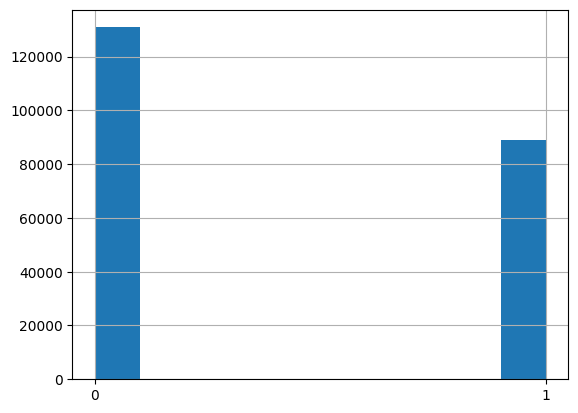

In [41]:
train_labels['label'].hist()

We observe from our plot that our data is a bit imbalanced with about 40:60 ratio of positive to negative samples. This should not present too much of an issue as we can re-balance the data through methods such as over-sampling and under-sampling to obtain a more equally distributed dataset.

Now we will take a look at samples of our data to have an idea what the images we will be working on actually look like. 
The code snippet below plots 16 random images from our training data. A rectangle box is drawn around the centre of image to draw focus to portion of the image that the diagnoses are based on. The positive samples are drawn with a red box while the negative samples are drawn with a blue box, in order to aid in spotting any features that might inform our training strategy.  

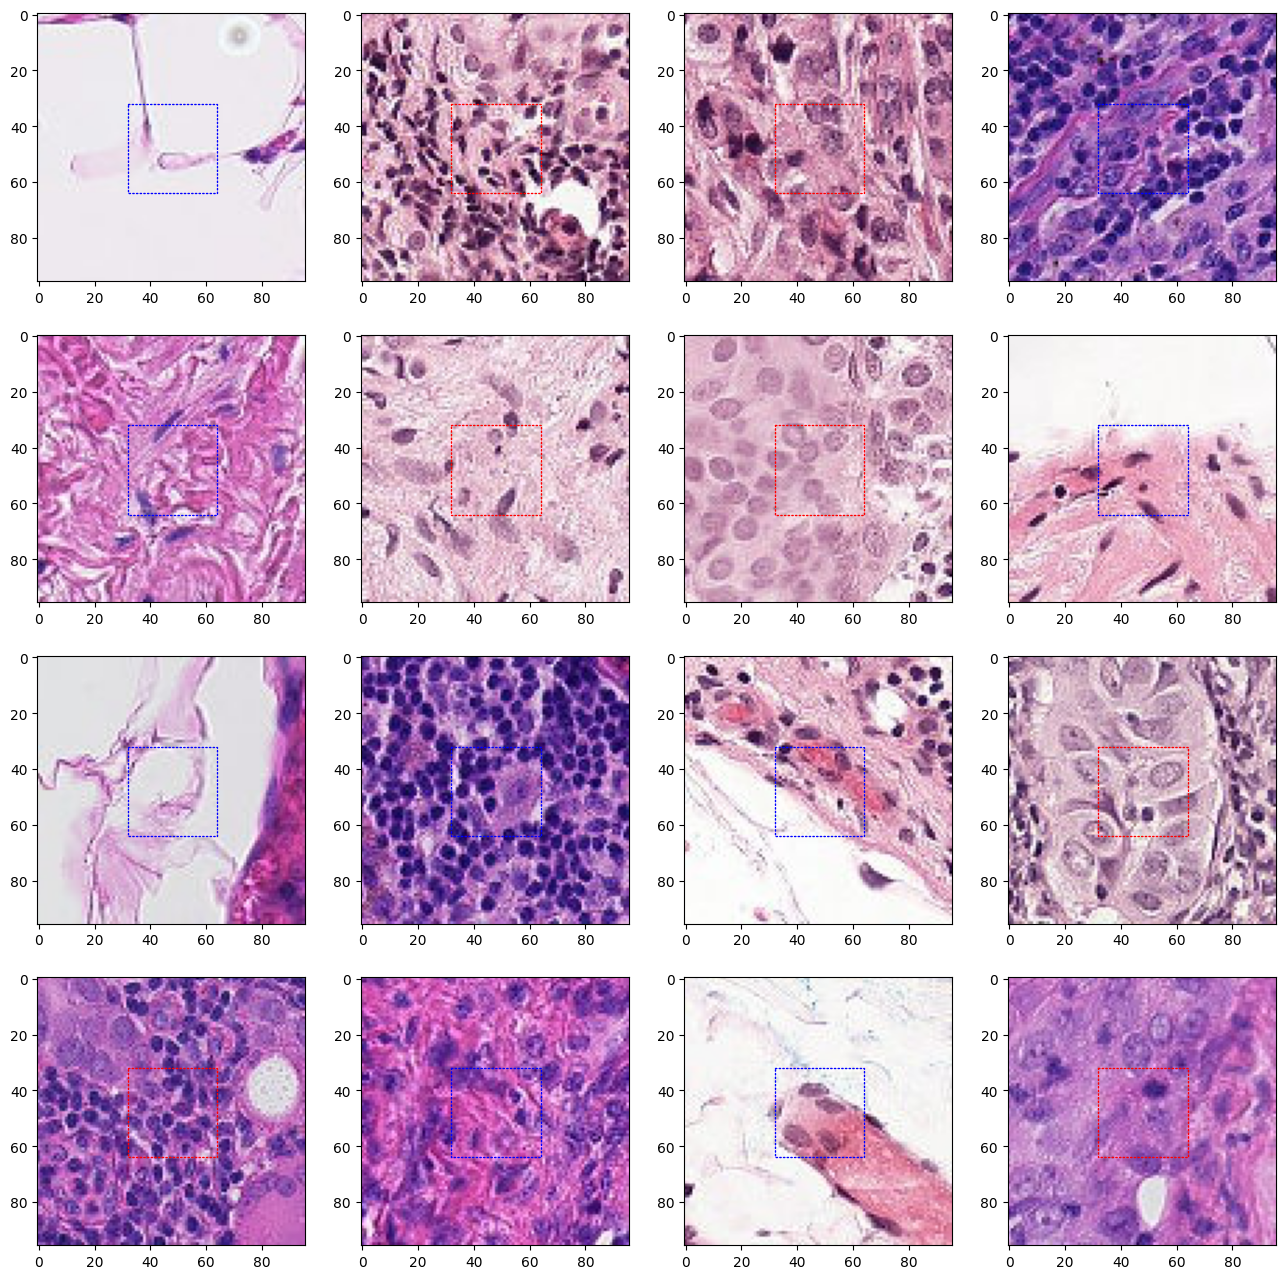

In [42]:
# load the image data files
plt.figure(1, figsize=(16, 16))
for samp, ind in zip(sample(list(train_labels['id']), 16), range(16)):
    lab_ind = list(train_labels['id']).index(samp)
    label = train_labels['label'][lab_ind]
    if label == '0': 
        c = 'b'
    else:
        c = 'r'
    img = cv2.imread('../input/histopathologic-cancer-detection/train/'+ samp)
    plt.subplot(4,4,ind+1)
    box = patches.Rectangle((32,32),32,32,linewidth=1,edgecolor=c,facecolor='none', linestyle=':', capstyle='round')
    plt.subplot(4,4,ind+1).add_patch(box)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


Unsurprisingly, it is nearly imporssible to discern the differences between the positive and negative samples without the benefit of years of study and  specialist training in this field. Fortunately, image classification is a task that has has coniderable success in the field of machine learning. In this project we will be employing Convolutional Neural Networks in an attempt to solve this problem.

### Data Pre-Processing and Augmentation
We use the ImageDataGenerator to prepare our data, dividing it into an 80:20 training to validation split. We also rescale the data values between 0 and 1 by dividing by 255. 
the Imagedatagenerator module also allows us to conveninetly carry out some augmentation on our sample images. In this case we perform 2 augmentation tasks, random rotation on some of our samples and adjustment of image brightness. These techniques are aimed at preventing our algorithms from overfitting during the training process by randomly introducing some variation to certain properties of ouyr images.   

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [120]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.20, rotation_range=90, brightness_range = [0.7, 1.3])

In [121]:
# Training Data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=data_dir+'train',
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=24,
    seed=985723,
    class_mode="binary",#
    target_size=(64,64)
    )

Found 176020 validated image filenames belonging to 2 classes.


In [122]:
# Validation Data Generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=data_dir+'train',
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=24,
    seed=985723,
    class_mode="binary",#
    target_size=(64,64)
    )

Found 44005 validated image filenames belonging to 2 classes.


### Convolutional Neural Network Model: Custom Architecture
Our model is a small custom architecture containing only 4 convolutional layers with a ReLU activation and a fully connected output layer with a sigmoid activation. The advantage of a small model is the speed of training and ease of deployment. Being simpler than a typical CNN model means it should also be less likely to overfit. 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (24, 62, 62, 8)           224       
                                                                 
 max_pooling2d_6 (MaxPooling  (24, 31, 31, 8)          0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (24, 31, 31, 8)           0         
                                                                 
 batch_normalization_6 (Batc  (24, 31, 31, 8)          32        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (24, 29, 29, 16)          1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (24, 14, 14, 16)        

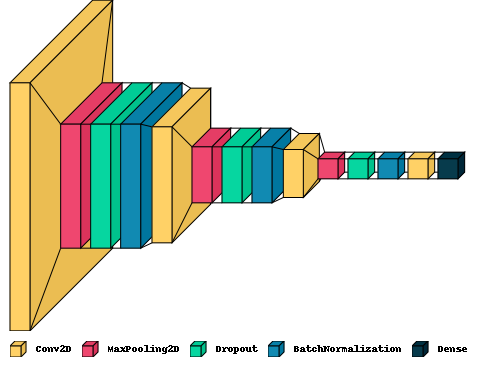

In [123]:
model1_auc = tf.keras.metrics.AUC()
   
#create model
model1 = Sequential()

model1.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.1))

model1.add(BatchNormalization())
model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.05))

model1.add(BatchNormalization())
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(3,3)))
model1.add(Dropout(0.05))

model1.add(BatchNormalization())
model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

#build model by input size
model1.build(input_shape=(24, 64, 64, 3)) # model1.build(input_shape=(batchSize = 24, 64, 64, 3))

#compile
adam_optimizer = Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', metrics=['accuracy', model1_auc], optimizer=adam_optimizer)

# Print out a Summary of model showing the different layers
model1.summary()

# A avery helpful visulaisation of the model architecture
visualkeras.layered_view(model1, type_ignore=[ZeroPadding2D, Flatten], legend=True)

In [48]:
EPOCHS = 10
# train the model
history_model1 = model1.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10


2023-06-11 15:05:24.949067: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7335/7335 [==============================] - 2076s 282ms/step - loss: 0.4486 - accuracy: 0.7955 - auc_1: 0.8650 - val_loss: 0.5571 - val_accuracy: 0.7708 - val_auc_1: 0.8898
Epoch 2/10
7335/7335 [==============================] - 1542s 210ms/step - loss: 0.3972 - accuracy: 0.8234 - auc_1: 0.8964 - val_loss: 0.3594 - val_accuracy: 0.8449 - val_auc_1: 0.9186
Epoch 3/10
7335/7335 [==============================] - 1113s 152ms/step - loss: 0.3639 - accuracy: 0.8421 - auc_1: 0.9137 - val_loss: 0.3382 - val_accuracy: 0.8561 - val_auc_1: 0.9286
Epoch 4/10
7335/7335 [==============================] - 1003s 137ms/step - loss: 0.3437 - accuracy: 0.8523 - auc_1: 0.9230 - val_loss: 0.3165 - val_accuracy: 0.8695 - val_auc_1: 0.9352
Epoch 5/10
7335/7335 [==============================] - 993s 135ms/step - loss: 0.3317 - accuracy: 0.8585 - auc_1: 0.9284 - val_loss: 0.3860 - val_accuracy: 0.8383 - val_auc_1: 0.9177
Epoch 6/10
7335/7335 [==============================] - 986s 134ms/step - loss: 0.3256 

We will use second model architecture below and then compare performance. But first let's plot our modle training performance.

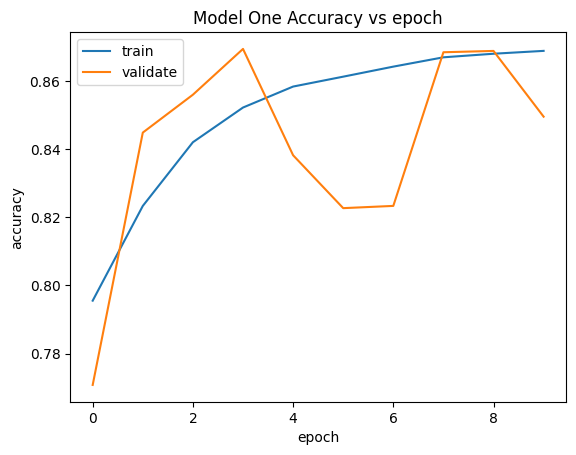

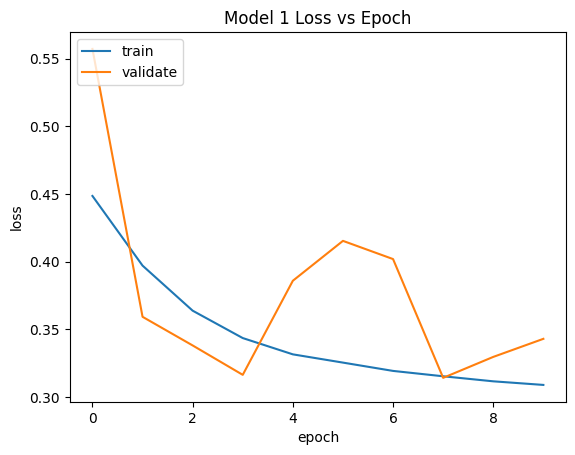

In [49]:
# plot model accuracy per epoch 
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

### Pre-Traied MobileNet Model
Now we are going to use a pre-trained mobilenet model and compare with our more basic model.

In [106]:
mobile = keras.applications.mobilenet.MobileNet(dropout=0.05)
#mobile.summary()

In [70]:
mobile.compile(loss='binary_crossentropy', metrics=['accuracy', model1_auc], optimizer=adam_optimizer)

In [124]:
base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(64, 64, 3), dropout =0.05) # uses pre-trained mobilenet model and discards the last 1000 neuron layer

x=base_model.output
x=GlobalAveragePooling2D()(x)

# Use a Dense fully-connected layer with a ReLU activation

x=Dense(1024,activation='relu')(x) 

x=Flatten()(x)
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation
model=Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                                   

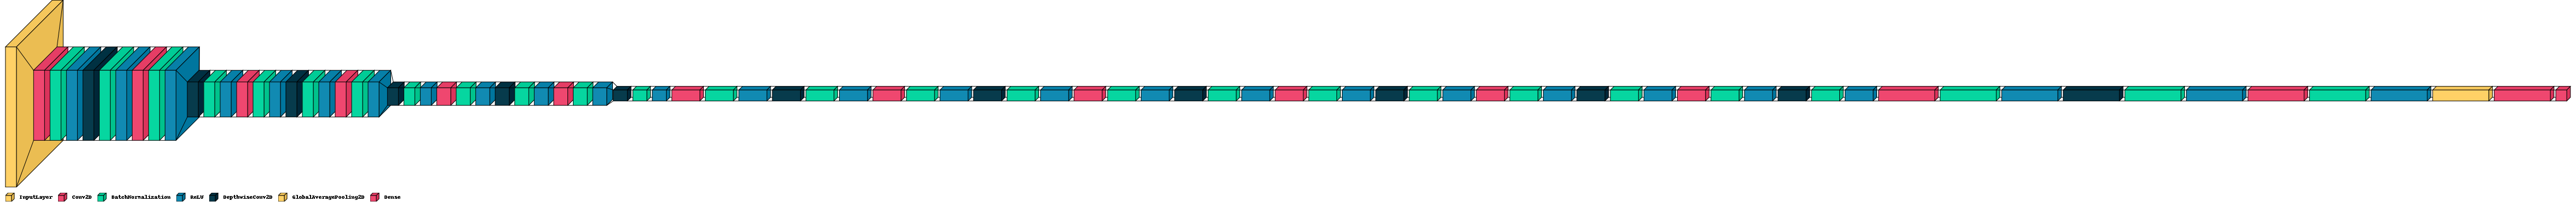

In [125]:
model.compile(loss='binary_crossentropy', metrics=['accuracy', model1_auc], optimizer=adam_optimizer)
visualkeras.layered_view(model, type_ignore=[ZeroPadding2D, Flatten], legend=True)

In [55]:
#
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.20, rotation_range=90, brightness_range = [0.7, 1.3])
# Training Data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=data_dir+'train',
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=24,
    seed=985723,
    class_mode="binary",#
    target_size=(64,64)
    )
# Validation Data Generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=data_dir+'train',
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=24,
    seed=985723,
    class_mode="binary",#
    target_size=(64,64)
    )
model1_auc = tf.keras.metrics.AUC()

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [126]:
EPOCHS = 10
# train the model
history_model2 = model.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10
7335/7335 [==============================] - 1014s 136ms/step - loss: 0.3354 - accuracy: 0.8587 - auc_3: 0.9271 - val_loss: 0.2975 - val_accuracy: 0.8773 - val_auc_3: 0.9445
Epoch 2/10
7335/7335 [==============================] - 988s 135ms/step - loss: 0.2635 - accuracy: 0.8937 - auc_3: 0.9545 - val_loss: 0.2469 - val_accuracy: 0.8988 - val_auc_3: 0.9603
Epoch 3/10
7335/7335 [==============================] - 1004s 137ms/step - loss: 0.2350 - accuracy: 0.9065 - auc_3: 0.9635 - val_loss: 0.2538 - val_accuracy: 0.8902 - val_auc_3: 0.9663
Epoch 4/10
7335/7335 [==============================] - 1007s 137ms/step - loss: 0.2201 - accuracy: 0.9131 - auc_3: 0.9679 - val_loss: 0.3288 - val_accuracy: 0.8569 - val_auc_3: 0.9513
Epoch 5/10
7335/7335 [==============================] - 996s 136ms/step - loss: 0.2098 - accuracy: 0.9181 - auc_3: 0.9706 - val_loss: 0.2122 - val_accuracy: 0.9188 - val_auc_3: 0.9731
Epoch 6/10
7335/7335 [==============================] - 1002s 137ms/step - lo

In [ ]:
# modest improvement inaccuracy using rotation augmentation


dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


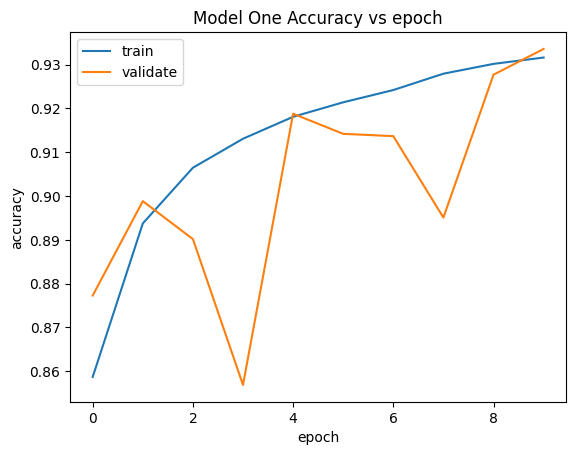

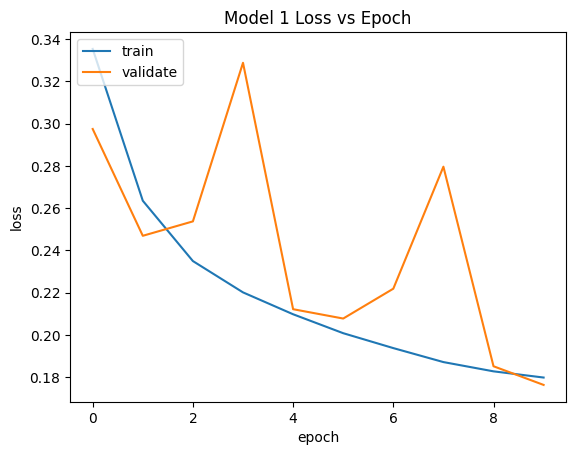

In [127]:
print(history_model1.history.keys())

# plot model accuracy per epoch 
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


### Results
We can see that the pre-trained MobileNet model performs better than our more basic model, although there is a strong tendency to overfitting.   

### Conclusion
It seem sthat there are benefits to using the pre-trained model on this task. The pre-tarined model is a much larger model and more complicated but in this task where the well-being of patients is involved, this should not cpunt against it as no corners should be cut. 

#### Competition Test Data Prediction and Submission
Below code is to predict on the test data and submit for the kaggle competition.

In [128]:
test_path = '../input/histopathologic-cancer-detection/test/'
test_df = pd.DataFrame({'id':os.listdir(test_path)})

In [129]:
datagen_test = ImageDataGenerator(rescale=1./255.)
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [130]:
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 465s 8ms/step


In [131]:
#create submission
predictions = np.transpose(predictions)[0]
submit_df = pd.DataFrame()
submit_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submit_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submit_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [132]:
submit_df.to_csv('submission.csv', index=False)